# Setting Up `neurodesign` and `deconvolve`

To work with the `neurodesign` and `deconvolve` packages for experiment creation, we recommend setting up a Python virtual environment. This ensures that your project dependencies remain isolated and reproducible.

---

**I. Clone and open the repository folder in Visual Studio Code.**

---

**II. Create a virtual environment**

You can do this either through the VS Code interface or directly in the terminal.

**A. Using VS Code GUI:**
1. Open the Command Palette:  
   `View > Command Palette`
2. Search for and select:  
   `Python: Select Interpreter`
3. Click:  
   `+ Create Environment`
4. Choose the environment type:  
   `venv`
5. Select a Python interpreter (version `>= 3.9`, e.g., `Python 3.13.1`)

**B. Using the Terminal:**

From the root of the project folder, run:
```bash
python -m venv venv
```

---

**III. Activate the virtual environment**

- On macOS/Linux:
  ```bash
  source venv/bin/activate
  ```
- On Windows:
  ```bash
  venv\Scripts\Activate.ps1
  ```

---

**IV. Install required packages**

With the virtual environment activated, install dependencies:
```bash
pip install git+https://github.com/neuropower/neurodesign.git
pip install -r requirements.txt
```

To deactivate the environment when you're done:
```bash
deactivate
```

---

**V. (Optional) Use the virtual environment in Jupyter Notebooks**

If you're working in `.ipynb` notebooks, register the virtual environment as a Jupyter kernel:
```bash
python -m ipykernel install --user --name=venv --display-name "Python (neurodesign venv)"
```

Reload VSC. Then, in Jupyter, select the `"Python (neurodesign venv)"` kernel when working on notebooks.

---

**Note:** At this stage, we are primarily using the `neurodesign` package.

---

## Comparing fMRI Experimental Designs Using Neurodesign


Commented code taken from the tutorial folder for Neurodesign GitHub [repository](https://github.com/neuropower/neurodesign/tree/master/examples)

We simulate and compare five different fMRI designs. The goal is to assess how changes in trial order and inter-trial interval (ITI) affect **estimation efficiency** (Fd), **detection power** (Ff), **collinearity** (Fc), and other metrics.

---

### 🧪 Experimental Setup

- **TR (Repetition Time):** 2 seconds
- **Stimuli:** 3 conditions with probabilities [0.3, 0.3, 0.4]
- **Number of Trials:** 20
- **Contrasts:** C1 vs C2, and C2 vs C3
- **Stimulus Duration:** 1s
- **Pre- and Post-Stimulus Periods:** 0.5s pre, 2s post (e.g., fixation + feedback)
- **ITI Distribution:** Exponential (min: 2s, mean: 2.1s, max: 4s)
- **Noise Autocorrelation (ρ):** 0.3

---

### 🔁 Design 1: Cyclical Order with Fixed ITI

This design repeats conditions 0, 1, 2 in sequence and uses a fixed 2-second ITI. It's balanced and orderly, but lacks temporal variability.

---

### 🧱 Design 2: Blocked Order with Jittered ITI

This design groups conditions in mini-blocks (e.g., 0,0, 1,1, 2,2...) and uses **exponentially distributed ITIs**, making it more naturalistic. This design introduces more variability, which helps reduce collinearity and potentially improves design efficiency.

---

### 🧬 Design 3 & 4: Genetic Crossover

Two new designs are generated by combining elements of Design 1 and Design 2 using a genetic crossover algorithm. These hybrids may benefit from the strengths of both parents (structure + jitter).

---

### 🧪 Design 5: Mutation of Design 1

This design introduces randomness (30% mutation rate) into the condition sequence of Design 1, potentially improving variability while keeping much of the original structure.

---

### 📊 Evaluation: Estimation Efficiency (Fd)

At the end, we compare the **Fd (estimation efficiency)** across all five designs to see which configuration is most statistically powerful for modeling condition-related BOLD responses.

This simulation highlights the importance of thoughtful design in fMRI: even modest changes in order or timing can substantially impact signal estimation quality.

---

## Initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import neurodesign

In [2]:
import os
# Since Neurodesign uses multi-threading internally, limit the number of threads
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

## Define experimental parameters

In [3]:
from rich import print
from neurodesign import generate

# -------------------------------
# DEFINE EXPERIMENTAL PARAMETERS
# -------------------------------

exp = neurodesign.Experiment(
    TR=2,                        # Repetition time (TR) of fMRI acquisition in seconds
    n_trials=20,                 # Number of trials (short toy example)
    P=[0.3, 0.3, 0.4],           # Condition probabilities: Condition 2 is slightly overrepresented
    C=[[1, -1, 0], [0, 1, -1]],  # Contrasts: C1 vs C2, C2 vs C3
    n_stimuli=3,                 # Total number of stimulus conditions
    rho=0.3,                     # Temporal autocorrelation in fMRI noise
    stim_duration=1,            # Duration of each stimulus (in seconds)
    t_pre=0.5,                  # Pre-stimulus baseline (e.g., fixation)
    t_post=2,                   # Post-stimulus period (e.g., feedback)
    ITImodel="exponential",     # Inter-trial interval (ITI) sampling model
    ITImin=2,                   # Minimum ITI
    ITImax=4,                   # Maximum ITI
    ITImean=2.1,                # Mean ITI
)

c:\Users\vguigon\Desktop\Research_directory\Lab_SLD\sld_simulating_fmri\venv\Lib\site-packages\neurodesign\classes.py:484: UserWarning: the resolution is adjusted to be a multiple of the TR. New resolution: 0.1
  warnings.warn(
c:\Users\vguigon\Desktop\Research_directory\Lab_SLD\sld_simulating_fmri\venv\Lib\site-packages\neurodesign\classes.py:643: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


## Design 1

Fd (Detection Efficiency): 0.16103147921659522

Fc (Collinearity): 0.29017603634298705

Ff (Detection Power): 0.8571428571428572

Fe (Frequency Balance): 19.97673295025123

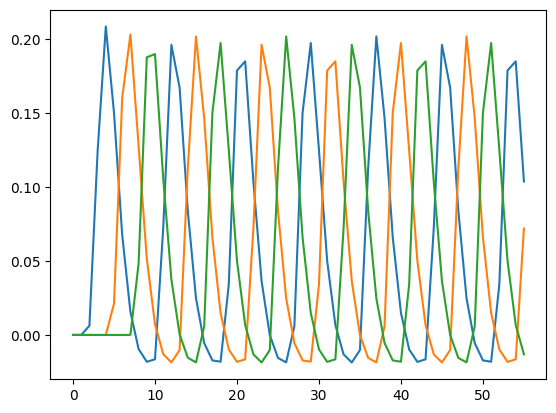

In [4]:
# -------------------------------
# DESIGN 1: CYCLIC ORDER + FIXED ITI
# -------------------------------

design_1 = neurodesign.Design(
    order=[0, 1, 2]*6 + [0, 1],  # Repeating sequence of conditions (C0, C1, C2)
    ITI=[2] * 20,               # Fixed ITI of 2 seconds for all trials
    experiment=exp,
)

# Compute the convolved design matrix and evaluate design quality
design_1.designmatrix()
design_1.FCalc(weights=[0, 0.5, 0.25, 0.25])  # Weighted evaluation of efficiency metrics
design_1.FdCalc()  # Estimation efficiency
design_1.FcCalc()  # Collinearity
design_1.FfCalc()  # Detection power
design_1.FeCalc()  # Frequency balance

plt.plot(design_1.Xconv) 
print(f"Fd (Detection Efficiency): {design_1.Fd}")
print(f"Fc (Collinearity): {design_1.Fc}")
print(f"Ff (Detection Power): {design_1.Ff}")
print(f"Fe (Frequency Balance): {design_1.Fe}")

## Design 2

Fd (Detection Efficiency): 0.20205159523865995

Fc (Collinearity): 0.5547984099943215

Ff (Detection Power): 0.8571428571428572

Fe (Frequency Balance): 213.1035197504768

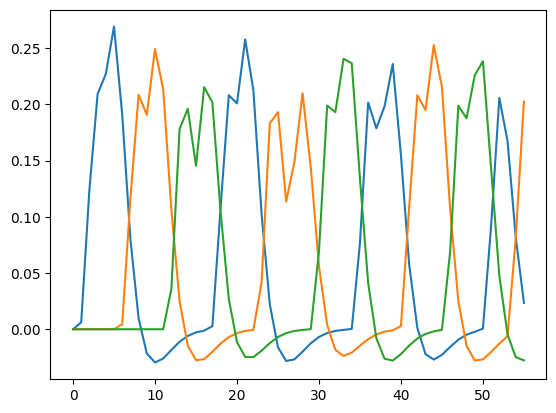

In [5]:
# -------------------------------
# DESIGN 2: BLOCKED ORDER + EXPONENTIAL ITI
# -------------------------------

design_2 = neurodesign.Design(
    order=[0, 0, 1, 1, 2, 2]*3 + [0, 1],  # Blocked condition order (2 reps per block)
    ITI=generate.iti(                   # ITIs drawn from exponential distribution
        ntrials=20, 
        model="exponential", 
        min=1, 
        mean=2, 
        max=4, 
        seed=1234
    )[0],
    experiment=exp,
)

design_2.designmatrix()
design_2.FeCalc()
design_2.FdCalc()
design_2.FcCalc()
design_2.FfCalc()

plt.plot(design_2.Xconv) 
print(f"Fd (Detection Efficiency): {design_2.Fd}")
print(f"Fc (Collinearity): {design_2.Fc}")
print(f"Ff (Detection Power): {design_2.Ff}")
print(f"Fe (Frequency Balance): {design_2.Fe}")

## Crossover: Designs 3 & 4

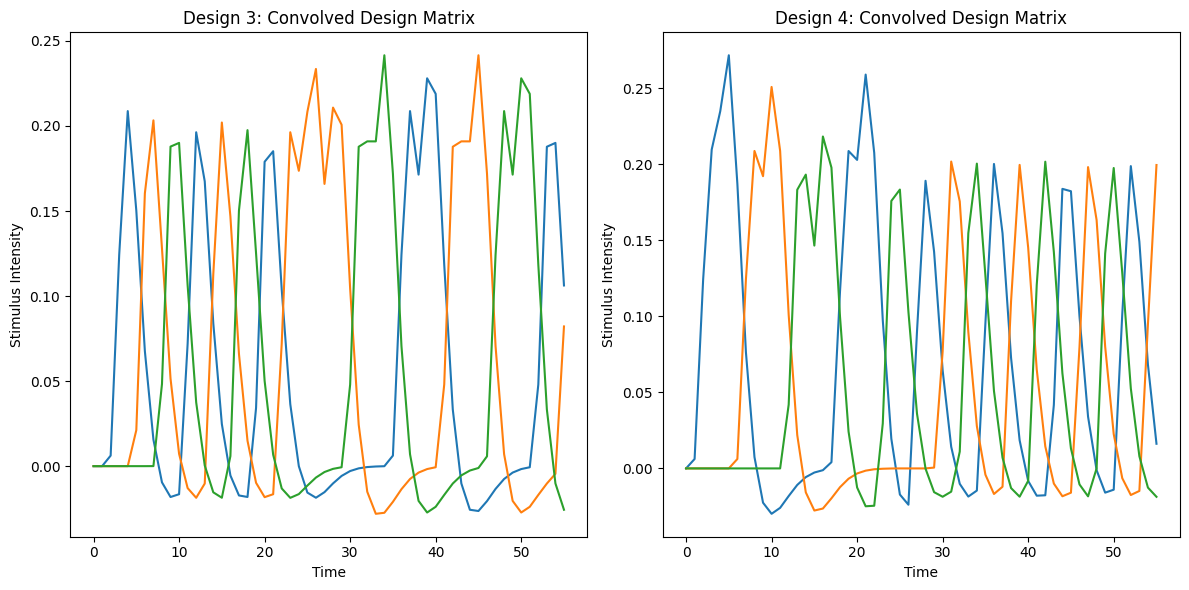

In [6]:
# -------------------------------
# CROSSOVER: DESIGN 3 & 4
# -------------------------------

design_3, design_4 = design_1.crossover(design_2, seed=2000)

design_3.order
design_3.designmatrix()
design_3.FeCalc()
design_3.FdCalc()
design_3.FcCalc()
design_3.FfCalc()

design_4.order
design_4.designmatrix()
design_4.FeCalc()
design_4.FdCalc()
design_4.FcCalc()
design_4.FfCalc()

# Create subplots for side-by-side plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot design_3 on the first axis
axes[0].plot(design_3.Xconv)
axes[0].set_title('Design 3: Convolved Design Matrix')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Stimulus Intensity')

# Plot design_4 on the second axis
axes[1].plot(design_4.Xconv)
axes[1].set_title('Design 4: Convolved Design Matrix')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Stimulus Intensity')

# Show the plots
plt.tight_layout()
plt.show()

## Mutation: Design 5

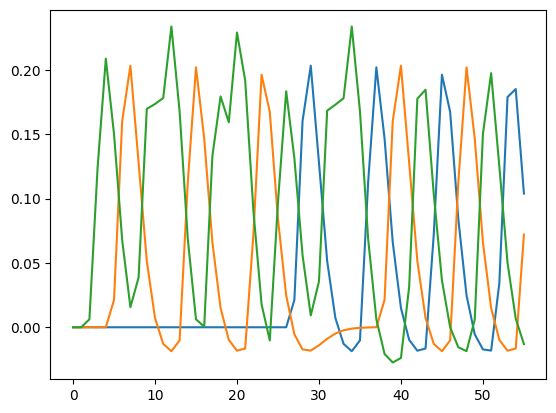

In [7]:
# -------------------------------
# MUTATION: DESIGN 5 (MODIFIED VERSION OF DESIGN 1)
# -------------------------------

design_5 = design_1.mutation(0.3, seed=2000)  # 30% mutation rate
design_5.designmatrix()
design_5.FeCalc()
design_5.FdCalc()
design_5.FcCalc()
design_5.FfCalc()

plt.plot(design_5.Xconv) 

## Scores

In [8]:
# -------------------------------
# SUMMARY OF ESTIMATION EFFICIENCIES (Fd)
# -------------------------------

result = (
    "RESULTS \n"
    "======= \n"
    f"DESIGN 1: Fd = {design_1.Fd} \n"
    f"DESIGN 2: Fd = {design_2.Fd} \n"
    f"DESIGN 3: Fd = {design_3.Fd} \n"
    f"DESIGN 4: Fd = {design_4.Fd} \n"
    f"DESIGN 5: Fd = {design_5.Fd} \n"
)

print(result)

RESULTS 
======= 
DESIGN 1: Fd = 0.16103147921659522 
DESIGN 2: Fd = 0.20205159523865995 
DESIGN 3: Fd = 0.18128746656250241 
DESIGN 4: Fd = 0.17055676574747416 
DESIGN 5: Fd = 0.13191052504025316

Fd – Estimation Efficiency: This measures how well the design allows for precise estimation of the shape and amplitude of the HRF (hemodynamic response) for each condition.  
We can observe that the design with the higher estimation efficiency is design 2, Blocked condition order (2 reps per block) with exponential ITI